# Produce lifetime XY map and write a dst corrected by lifetime and energy scale

### Run number

In [3]:
import os

run_number          = 6205

input_dst_filename  = os.path.expandvars(f"$IC_DATA/dst/dst_{run_number}.h5")
lt_filename         = os.path.expandvars(f"$IC_DATA/maps/lt_{run_number}.h5")
output_dst_filename = os.path.expandvars(f"$IC_DATA/ldst/dst_{run_number}.h5")

print(f"run number  = {run_number}")
print(f"input dst   = {input_dst_filename}")
print(f"lt_filename ={lt_filename}")
print(f"output dst  ={output_dst_filename}")

run number  = 6205
input dst   = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6205.h5
lt_filename =/Users/jjgomezcadenas/Projects/ICDATA/maps/lt_6205.h5
output dst  =/Users/jjgomezcadenas/Projects/ICDATA/ldst/dst_6205.h5


### Notebook configuration

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import matplotlib.pyplot as plt
# Plotting style
default_cmap = "jet"

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"

In [6]:
import os
import time
import datetime
import collections
import glob

import tables            as tb
import numpy             as np
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
import invisible_cities.reco    .corrections    as corrf

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [7]:
from core.kr_types import KrEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import kr_event
from core.kr_types import kr_times_ranges_and_bins
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits
from core.kr_types import DstEvent, NevtDst

from   invisible_cities.evm  .ic_containers  import Measurement

In [8]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [9]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [10]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [11]:
from typing      import NamedTuple

In [12]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

In [13]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Thu Jul 12 21:35:37 2018


### Local data classes

In [14]:
class Ndst(NamedTuple):
    full  : int
    fid   : int
    core  : int
    hcore : int


class EffDst(NamedTuple):
    full  : float
    fid   : float
    core  : float
    hcore : float

### Read data

In [15]:
#dst = dstio.load_dsts(glob.glob(input_dst_filenames), "DST", "Events")
dst            = dstf.load_dst(input_dst_filename, "DST", "Events")

In [16]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 2302237


In [17]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [18]:
krTimes, krRanges, krNBins, krBins = kr_times_ranges_and_bins(dst,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 15e3),
                                                              S1range = (   0,   30),
                                                              Qrange  = ( 100, 1500),
                                                              Znbins        =   10,
                                                              XYnbins       =   40,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

In [19]:
print(krRanges, krNBins)

KrRanges(Z=(100, 550), XY=(-200, 200), E=(2000.0, 15000.0), S1=(0, 30), Q=(100, 1500), T=(1531308400.6990001, 1531421689.681)) KrNBins(Z=10, XY=40, E=50, S1=20, Q=25, T=31)


In [66]:
krTimes.timeStamps

[datetime.datetime(2018, 7, 11, 13, 57, 7, 940645),
 datetime.datetime(2018, 7, 11, 14, 58, 2, 423936),
 datetime.datetime(2018, 7, 11, 15, 58, 56, 907226),
 datetime.datetime(2018, 7, 11, 16, 59, 51, 390516),
 datetime.datetime(2018, 7, 11, 18, 0, 45, 873806),
 datetime.datetime(2018, 7, 11, 19, 1, 40, 357097),
 datetime.datetime(2018, 7, 11, 20, 2, 34, 840387),
 datetime.datetime(2018, 7, 11, 21, 3, 29, 323678),
 datetime.datetime(2018, 7, 11, 22, 4, 23, 806968),
 datetime.datetime(2018, 7, 11, 23, 5, 18, 290258),
 datetime.datetime(2018, 7, 12, 0, 6, 12, 773549),
 datetime.datetime(2018, 7, 12, 1, 7, 7, 256839),
 datetime.datetime(2018, 7, 12, 2, 8, 1, 740129),
 datetime.datetime(2018, 7, 12, 3, 8, 56, 223419),
 datetime.datetime(2018, 7, 12, 4, 9, 50, 706710),
 datetime.datetime(2018, 7, 12, 5, 10, 45, 190000),
 datetime.datetime(2018, 7, 12, 6, 11, 39, 673290),
 datetime.datetime(2018, 7, 12, 7, 12, 34, 156581),
 datetime.datetime(2018, 7, 12, 8, 13, 28, 639871),
 datetime.datetim

In [ ]:
T   =(kdstc.T - kdstc.T.min()) 
t, e, eu = fitf.profileX(T, kdstc.E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ekr = kdstc.E * ET_correction(T).value
tc, ec, euc = fitf.profileX(T, Ekr, 100)

### Fiducial volumes

In [20]:
R_full   = 200
R_fid    = 150
R_core   = 100
R_hcore  =  50
print(f" Rfull : {R_full}: Rfiducial : {R_fid}: Rcore = {R_core} Rhcore = {R_hcore} ")

 Rfull : 200: Rfiducial : 150: Rcore = 100 Rhcore = 50 


In [21]:

dst_full   = dst[dst.R < R_full]
dst_fid    = dst[dst.R < R_fid]
dst_core   = dst[dst.R < R_core]
dst_hcore  = dst[dst.R < R_hcore]

n_dst  = len(dst)

ndst = Ndst(full  = len(dst_full), 
            fid   = len(dst_fid), 
            core  = len(dst_core), 
            hcore = len(dst_hcore))

effdst = EffDst(full  = ndst.full  / n_dst, 
                fid   = ndst.fid   / n_dst, 
                core  = ndst.core  / n_dst, 
                hcore = ndst.hcore / n_dst)
print(ndst)
print(effdst)

Ndst(full=2258872, fid=1275152, core=557047, hcore=138281)
EffDst(full=0.9811639722582862, fid=0.5538752091987055, core=0.24195901638276163, hcore=0.06006375538226516)


In [22]:
kdst= DstEvent(full  = kr_event(dst_full),
               fid   = kr_event(dst_fid),
               core  = kr_event(dst_core),
               hcore = kr_event(dst_hcore))

### Event distribution

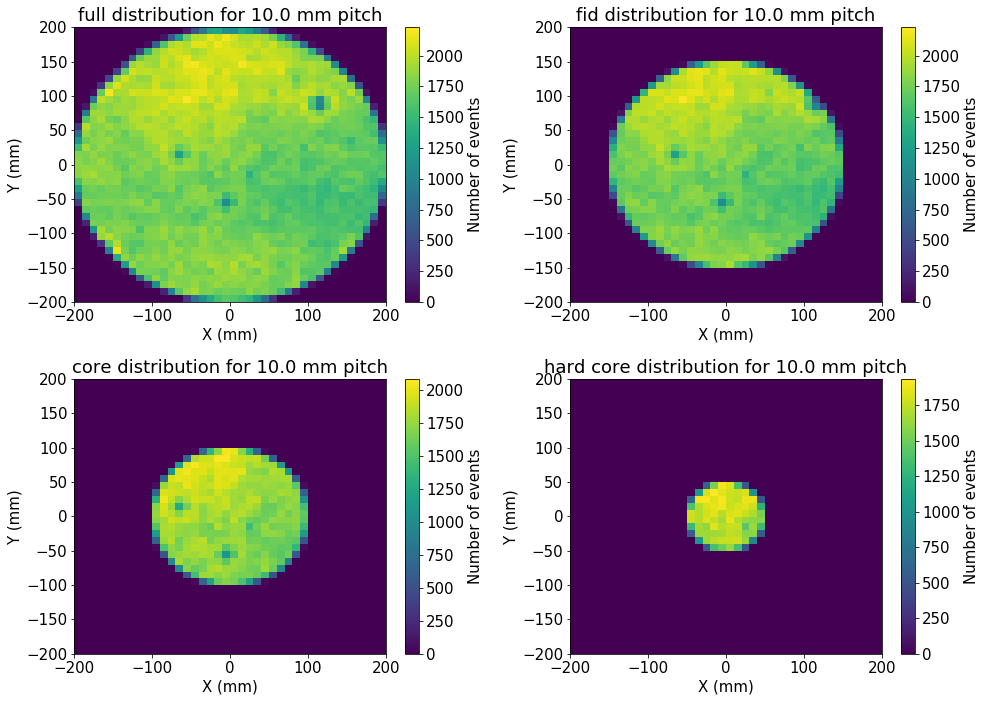

In [23]:
nEvt = krp.plot_xy_density(kdst, krBins)

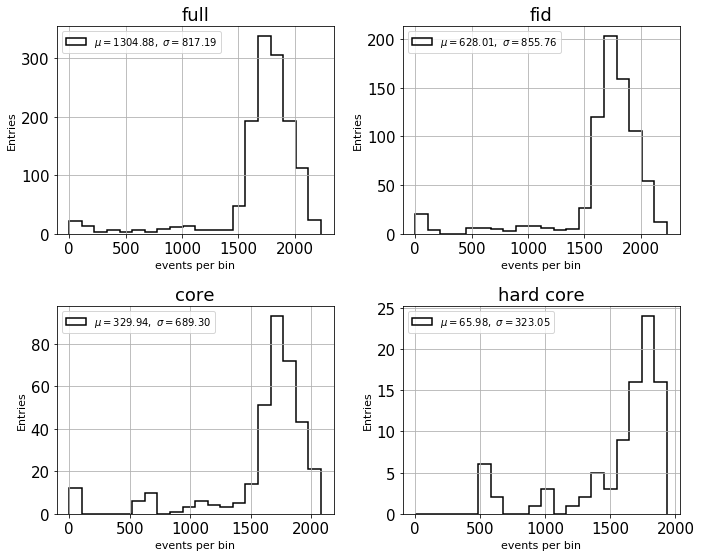

In [24]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names = ("nevt_full", "fnevt_id", "nevt_core", "nevt_hard core"),
                h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
                bins = (20, 20, 20, 20),
                ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
               (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
               xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
               ylabels = ("Entries", "Entries", "Entries", "Entries"),
               titles = ("full", "fid", "core", "hard core"),
               legends = ("upper left", "upper left", "upper left", "upper left"),
               figsize =(10,8))

### Evolution of S12 with time full

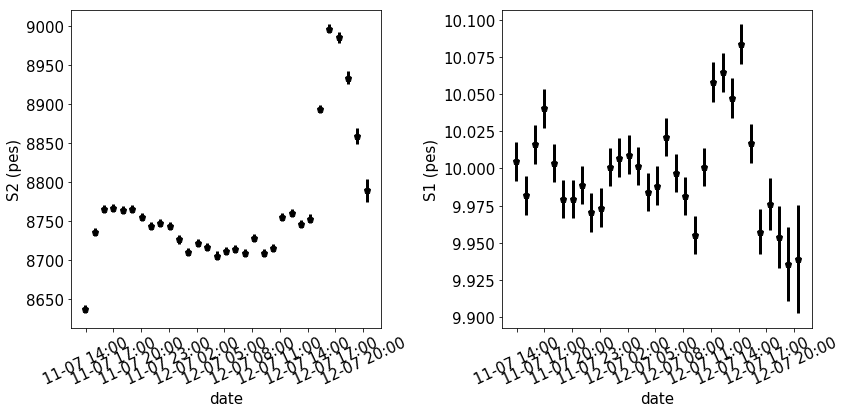

In [25]:
krf.s12_time_profile(kdst.full, krNBins.T, krRanges.T, krTimes.timeStamps, figsize=(12,6))

### Evolution of S12 with time hard core

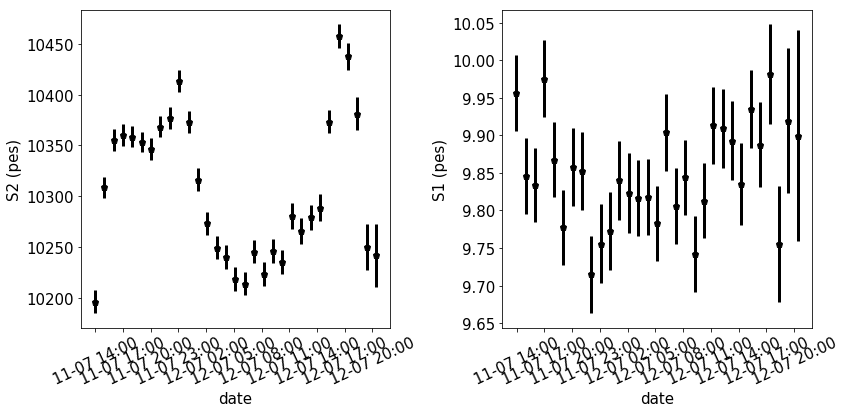

In [26]:
krf.s12_time_profile(kdst.hcore, krNBins.T, krRanges.T, krTimes.timeStamps, figsize=(12,6))

### S2 & S1 full

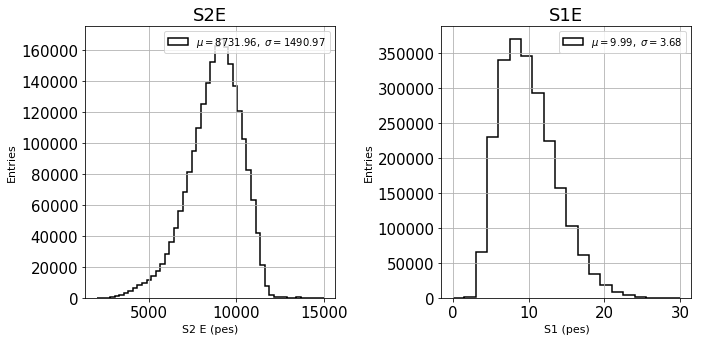

In [27]:
stats = krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.full.E, kdst.full.S1), bins=(krNBins.E, krNBins.S1), 
                names = ('S2E','S1E'),
                ranges =(krRanges.E, krRanges.S1),
                xlabels =('S2 E (pes)','S1 (pes)'),
                ylabels =('Entries','Entries'),
                titles = ('S2E','S1E'),
                legends = ('best','best'),
                figsize =(10,5))

In [28]:
stats

{'S1E': Measurement(value=9.9891956724787896, uncertainty=3.6783933540178424),
 'S2E': Measurement(value=8731.9643023175886, uncertainty=1490.96956313135)}

In [29]:
krNBins

KrNBins(Z=10, XY=40, E=50, S1=20, Q=25, T=31)

In [30]:
krRanges

KrRanges(Z=(100, 550), XY=(-200, 200), E=(2000.0, 15000.0), S1=(0, 30), Q=(100, 1500), T=(1531308400.6990001, 1531421689.681))

In [31]:
def s1_s2_rz_cut(dst, rmax=200, zmin=0, zinterval=600):
    
    fig, ax = plt.subplots(1, 3, figsize=(16,6))
    sel = (dst.R < rmax) & (in_range(dst.Z, zmin, zmin + zinterval))
    
    plt.axes(ax[0])
    
    ax[0].set_xlabel("S2 (pes)",fontsize = 11)
    ax[0].set_ylabel("Entries", fontsize = 11)
    y, edges, _ = ax[0].hist(dst.S2e[sel],
                             bins= krNBins.E,
                             range=krRanges.E,
                             histtype='step',
                             edgecolor='black',
                             linewidth=1.5)
    
    #x = shift_to_bin_centers(edges)
    
    #seed = np.max(y), x[np.argmax(y)], np.std(y)
    #f    = fitf.fit(fitf.gauss, x, y, seed, fit_range=[x[np.argmax(y)]-1000,x[np.argmax(y)]+1000])
    #ax[0].plot(x, f.fn(x), 'r')
    #ax[0].text(4000, 0.9*np.max(y), f'R = {100*f.values[2]*2.35/f.values[1]:.2f}%')
    
    ax[1].set_xlabel("S1 (pes)",fontsize = 11)
    ax[1].set_ylabel("Entries", fontsize = 11)
    y, edges, _ = ax[1].hist(dst.S1e[sel],
                             bins= krNBins.S1,
                             range=krRanges.S1,
                             histtype='step',
                             edgecolor='black',
                             linewidth=1.5)
    
    ax[2].hist2d(dst.S1e[sel], dst.S2e[sel], 100, [[0, 30],[2000, 15000]])
    ax[2].set_xlabel('S1 energy (pes)')
    ax[2].set_ylabel('S2 energy (pes)')
    fig.tight_layout()

In [32]:
w = interactive(s1_s2_rz_cut, dst=fixed(dst), rmax=(0, 200, 10), zmin=(0,600), zinterval=(0,600))
display(w)

interactive(children=(IntSlider(value=200, description='rmax', max=200, step=10), IntSlider(value=0, description='zmin', max=600), IntSlider(value=600, description='zinterval', max=600), Output()), _dom_classes=('widget-interact',))

### S2 & S1 hard core

{'S1E': Measurement(value=9.8276984522182307, uncertainty=3.5688525730490017),
 'S2E': Measurement(value=10245.347748831351, uncertainty=826.39954933266119)}

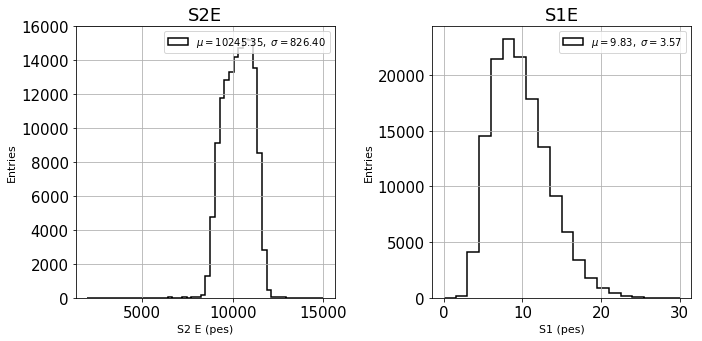

In [33]:
krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.hcore.E, kdst.hcore.S1), bins=(krNBins.E, krNBins.S1), 
        names=('S2E','S1E'),
    ranges =(krRanges.E, krRanges.S1),
    xlabels =('S2 E (pes)','S1 (pes)'),
    ylabels =('Entries','Entries'),
    titles = ('S2E','S1E'),
    legends = ('best','best'),
    figsize =(10,5))

### S2 vs Z

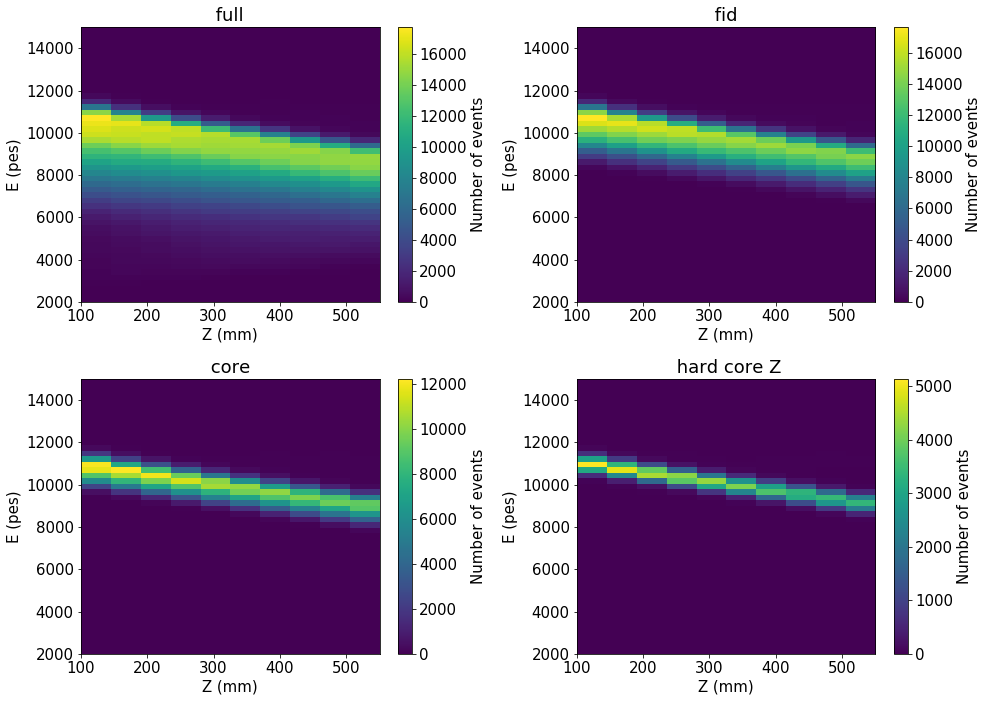

In [34]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

### Fit lifetime in hard core

 E (z=0) = 11568.025649347981 +-2.8704314038071086 
 LT      = -2296.3844069604893 +-4.216996249624639 
 chi2    = 2.4789507548476406 


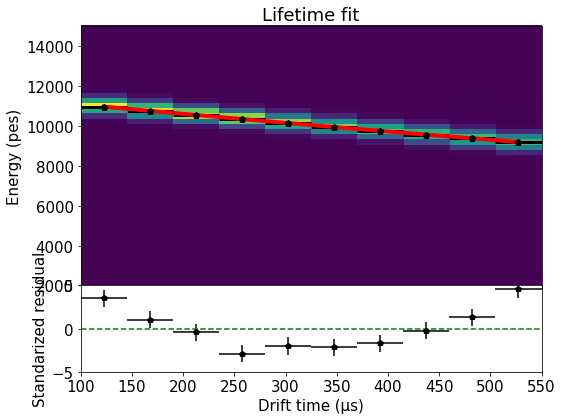

In [35]:
xlim =  -50, 50
ylim =  -50, 50
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst.hcore, krNBins, krBins, krRanges, xyr)
krf.print_fit(kf)

### Fit lifetime in core

 E (z=0) = 11315.223841013016 +-1.9473118882250684 
 LT      = -2270.2308493276983 +-2.7758881903443062 
 chi2    = 3.174231659514179 


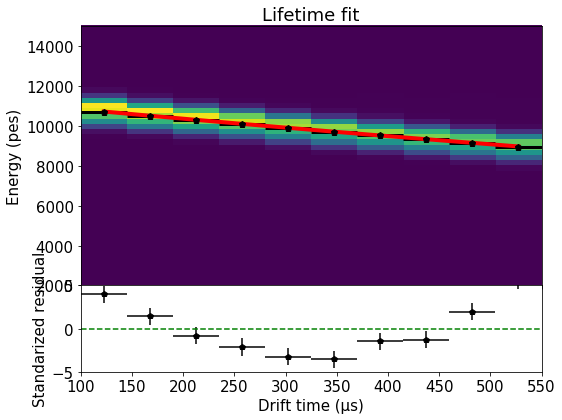

In [36]:
xlim =  -100, 100
ylim =  -100, 100
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst.core, krNBins, krBins, krRanges, xyr)
krf.print_fit(kf)

### Fit in four quadrants

xlim = (-125, -75), ylim =(-125, -75)
xlim = (-125, -75), ylim =(75, 125)
xlim = (75, 125), ylim =(75, 125)
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11120.958887239856 +-5.98578259801852 
 LT      = -2335.9830580410535 +-9.104427091531559 
 chi2    = 2.0566990682474584 
 E (z=0) = 10165.689524167765 +-6.619391934237242 
 LT      = -2121.5662532990636 +-9.194085732639667 
 chi2    = 1.2170175487440626 
 E (z=0) = 9811.66913614806 +-6.753730495200715 
 LT      = -2096.4408776836194 +-9.564617248171672 
 chi2    = 1.1324453269383714 
 E (z=0) = 10248.93796087618 +-6.652581833025055 
 LT      = -2291.643465029361 +-10.679145152884342 
 chi2    = 1.2382018785754183 


[None, None, None, None]

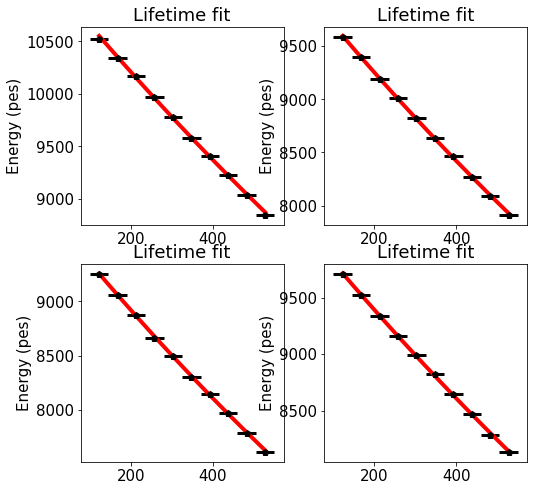

In [37]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

### Fit low and hig regions

xlim = (-100, 100), ylim =(125, 200)
xlim = (0, 200), ylim =(-50, 50)
 E (z=0) = 9552.062505636673 +-4.677022549428244 
 LT      = -1997.5709821417468 +-6.380293927560824 
 chi2    = 0.9823603751524681 
 E (z=0) = 10896.067492379678 +-3.762951815672175 
 LT      = -2286.272397115076 +-5.554114978915536 
 chi2    = 1.9161642139170156 


[None, None]

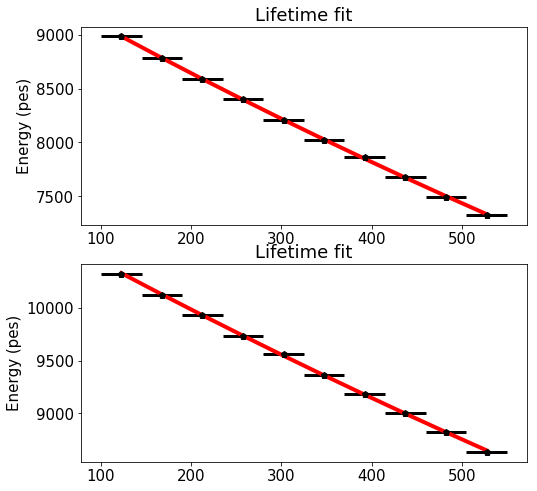

In [38]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-100, 100), (0, 200)],
                         YL = [(125, 200), (-50, 50)],
                         nx = 2, ny = 1, 
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

In [39]:
KF

[KrFit(par=array([ 9552.06250564, -1997.57098214]), err=array([ 4.67702255,  6.38029393]), chi2=0.9823603751524681),
 KrFit(par=array([ 10896.06749238,  -2286.27239712]), err=array([ 3.76295182,  5.55411498]), chi2=1.9161642139170156)]

In [40]:
es_low = KF[0].par[0]
esu_low = KF[0].err[0]
es_hig = KF[1].par[0]
esu_hig = KF[1].err[0]
lt_low = np.abs(KF[0].par[1])
ltu_low = np.abs(KF[0].err[1])
lt_hig = np.abs(KF[1].par[1])
ltu_hig = np.abs(KF[1].err[1])
print(f"LOW:  es +- err = {es_low} +- {esu_low}")
print(f"High:  es +- err = {es_hig} +- {esu_hig}")
print(f"LOW:  lt +- err = {lt_low} +- {ltu_low}")
print(f"High:  lt +- err = {lt_hig} +- {ltu_hig}")

LOW:  es +- err = 9552.062505636673 +- 4.677022549428244
High:  es +- err = 10896.067492379678 +- 3.762951815672175
LOW:  lt +- err = 1997.5709821417468 +- 6.380293927560824
High:  lt +- err = 2286.272397115076 +- 5.554114978915536


### Time profile of LT in the fiducial

In [41]:
fits = krf.lifetimes_in_TRange(kdst.fid, krNBins, krBins, krRanges,  TL=krTimes.TL)

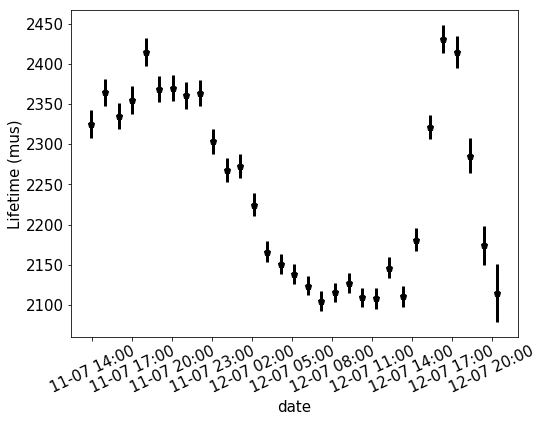

In [42]:
krp.plot_lifetime_T(fits, krTimes.timeStamps)

### Time profile of LT in hard core

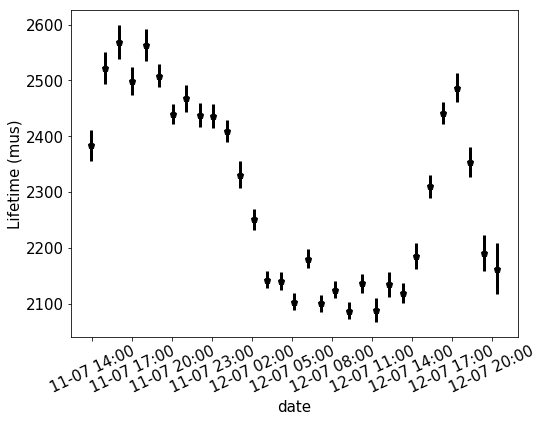

In [43]:
fits = krf.lifetimes_in_TRange(kdst.hcore, krNBins, krBins, krRanges,  TL=krTimes.TL)
krp.plot_lifetime_T(fits, krTimes.timeStamps)

### Compute lifetime maps

In [44]:
krfs = krf.fit_lifetime_slices(kdst.full, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [45]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [46]:
valid.shape

(40, 40)

In [47]:
np.count_nonzero(valid) / (valid.shape[0] * valid.shape[1])

0.805625

In [48]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =2056.5502743404454 +- 360.28222645238804
Lifetime uncertainty     : mu +- std =1.9532085626473907 +- 1.827409752523366
Energy scale value       : mu +- std =9874.842173479525 +- 1420.7730041979942
Energy scale uncertainty : mu +- std =0.33509613154386114 +- 0.42618612673349554


In [49]:
n_sigma  = 2.5
u_sigma  = 2.5
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 6322.909662984539; E_max = 13426.77468397451
 Lifetime (ELT): ELT_min = 1155.8447082094754; ELT_max = 2957.2558404714155
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 1.4005614483776
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 6.521732943955806


### Map display

In [50]:
krh.h1n(4, 2, 2, (Escale.value[valid],Escale.uncertainty[valid],
          ELT.value[valid],ELT.uncertainty[valid]),
          (20,20,20,20),
          (kltl.Es.interval,kltl.Eu.interval,kltl.LT.interval,kltl.LTu.interval),
          ('Energy at z=0 (pes)','Energy at z=0 (u %)','Lifetime (mus)', 'Lifetime (u %)'),
          ('Entries','Entries','Entries','Entries'),
          titles  =None,
          legends = ('best','best','best','best'),
          figsize =(8,8))


TypeError: h1n() missing 1 required positional argument: 'ylabels'

In [51]:
invalid = ~valid
mask = valid

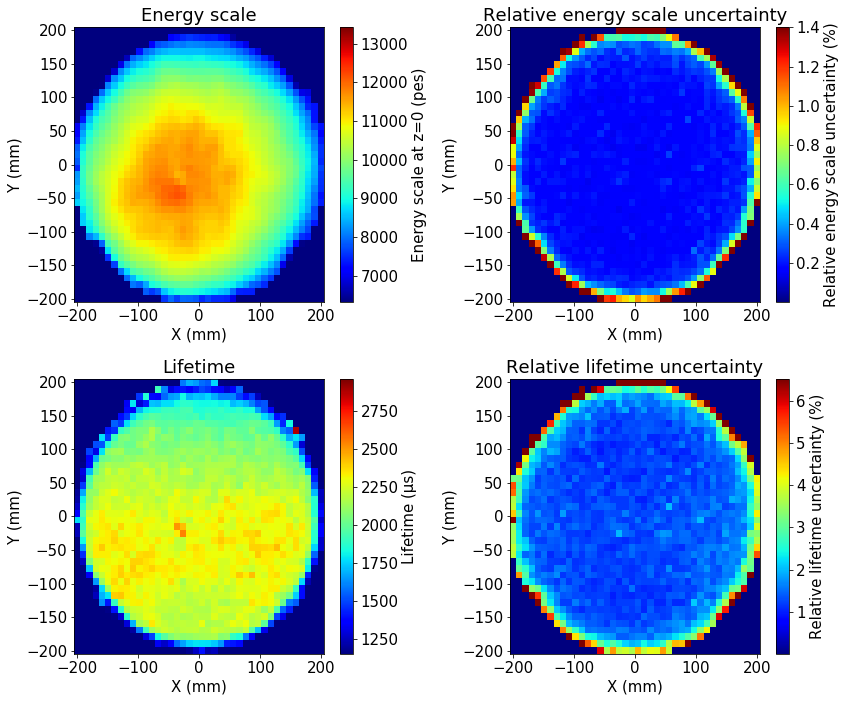

In [52]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="jet", mask=valid)
                         

(1.2103560632698021, 0.7478326209735664)

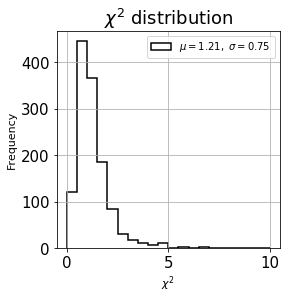

In [53]:
krp.figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

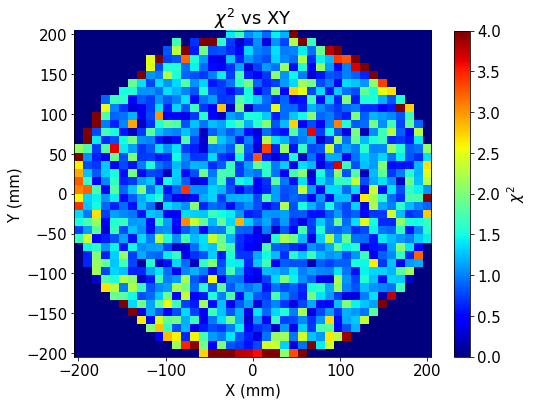

In [54]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(krBins.cXY, krBins.cXY, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

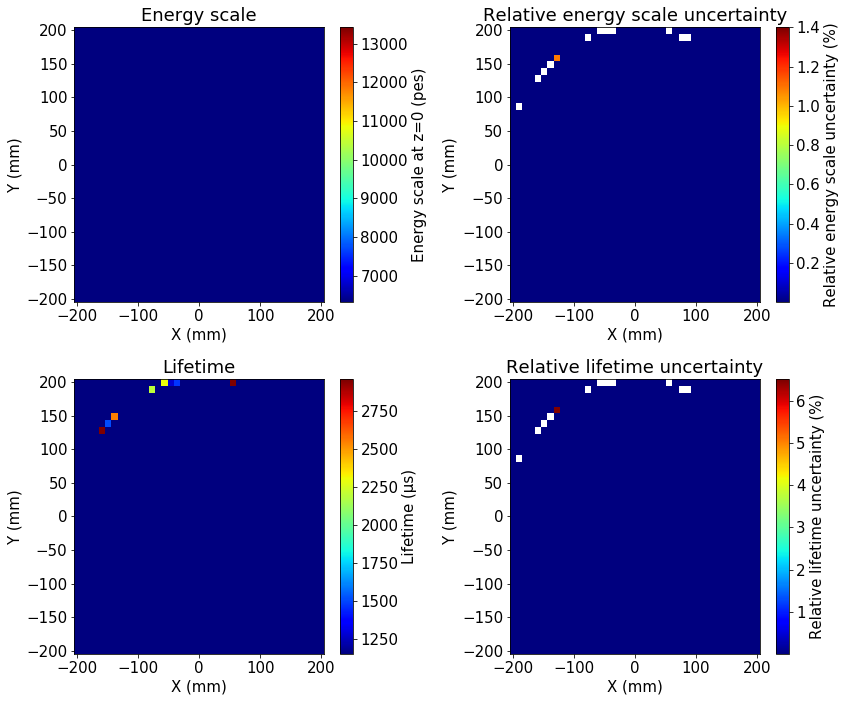

In [55]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="jet", mask=invalid)

### Fix map

- Fit fails in the corona
- Fill bins where fit has failed with average low level of lifetime


Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value      ,     Es.mu), 
                     np.where(valid, Escale_abs.uncertainty,       Es.mu_u * Es.mu / 100 ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , El.mu), 
                  np.where(valid,  ELT_abs.uncertainty,    El.mu_u * El.mu / 100))

In [56]:
Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value ,     es_low), 
                     np.where(valid, Escale_abs.uncertainty,       esu_low ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , lt_low), 
                  np.where(valid,  ELT_abs.uncertainty,    ltu_low))

In [57]:
Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
ELT_corr        = to_relative(ELT_abs_corr, percentual=True)

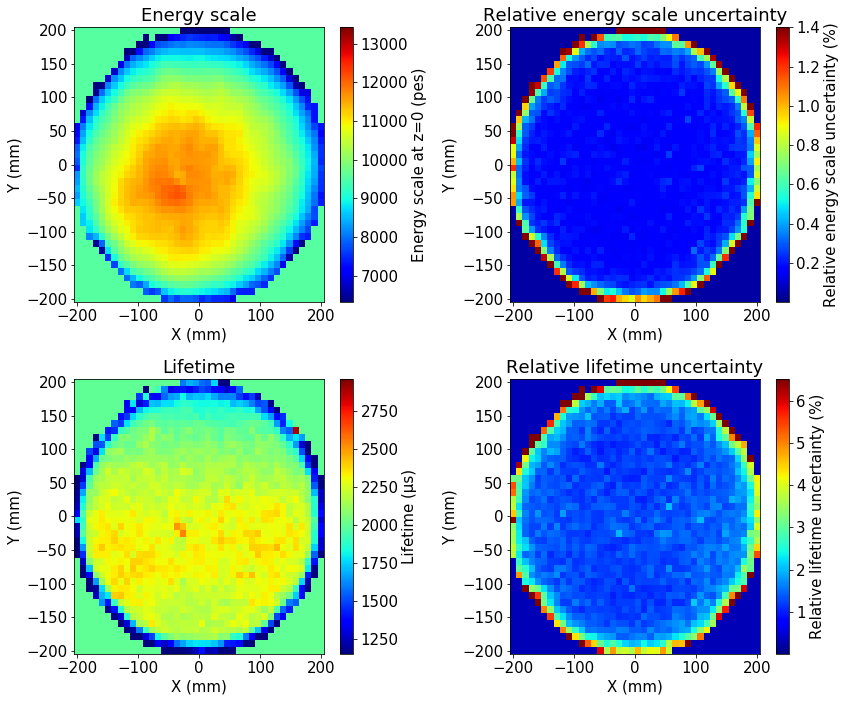

In [58]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=None)

In [59]:
gvalid   = np.zeros((krNBins.XY,krNBins.XY), dtype=bool)

In [60]:
def gfid(gvalid):
    for i in range(krNBins.XY):
        for j in range(krNBins.XY):
            if  np.sqrt(krBins.cXY[i]**2 + krBins.cXY[j]**2) < krRanges.XY[1] :
                    gvalid[i, j] = True

In [61]:
gfid(gvalid)

In [62]:
np.count_nonzero(gvalid) / (gvalid.shape[0] * gvalid.shape[1])

0.79

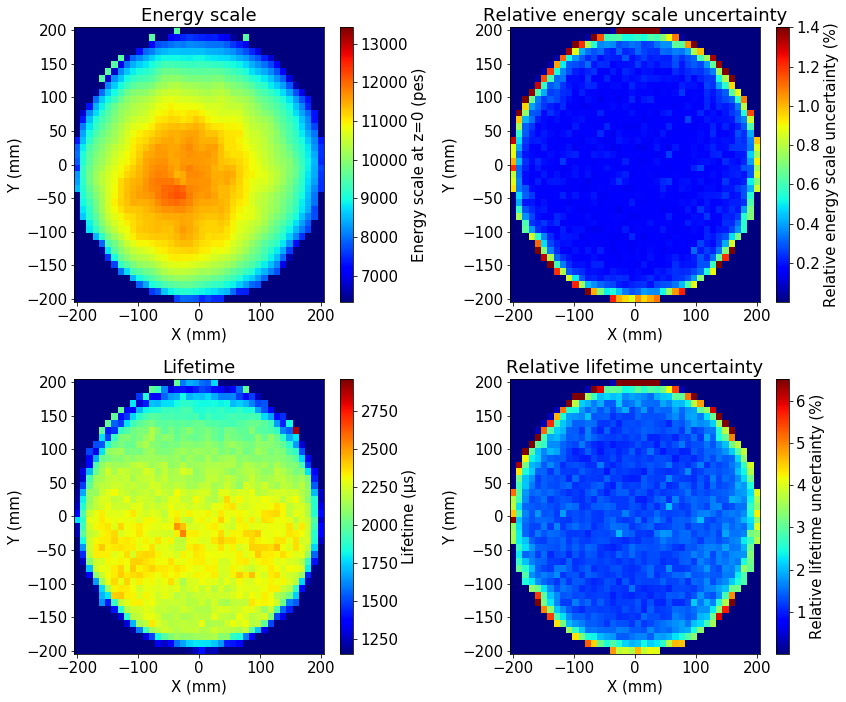

In [63]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=gvalid)

### Produce HDF5 output

In [63]:
nevt = nEvt.fid

In [64]:
print(lt_filename)

/Users/jjgomezcadenas/Projects/ICDATA/maps/lt_6205.h5


In [65]:
with tb.open_file(lt_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(krBins.cXY, krBins.cXY, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = krBins.pXY

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(krBins.cXY, krBins.cXY, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = krBins.pXY



### Load Z correction function

In [66]:
ZcorrectionE = dstf.load_lifetime_xy_corrections(lt_filename,
                                                 group = "XYcorrections",
                                                 node  = "Lifetime")

### Correct DST by lifetime

In [67]:
E = np.copy(dst.S2e.values)

In [68]:

dst.S2e = dst.S2e.values * ZcorrectionE(dst.Z, dst.X, dst.Y).value

In [69]:
Ec = dst.S2e.values

{'Ecorr ': Measurement(value=9850.9315065204119, uncertainty=1520.22211812245),
 'Eraw ': Measurement(value=8661.7857598051269, uncertainty=1570.5837860951508)}

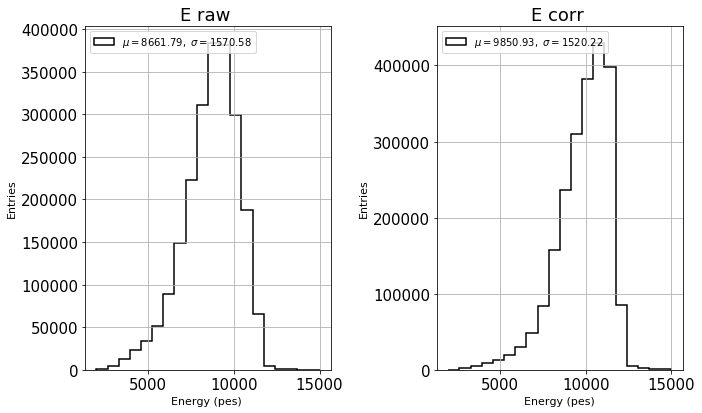

In [70]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (E, Ec),
    bins = (20, 20),
    names = ("Eraw ", "Ecorr "),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E raw ", "E corr "),
    legends = ("upper left", "upper left"),
    figsize =(10,6))

### Time profile

In [71]:
kdstc= kr_event(dst)

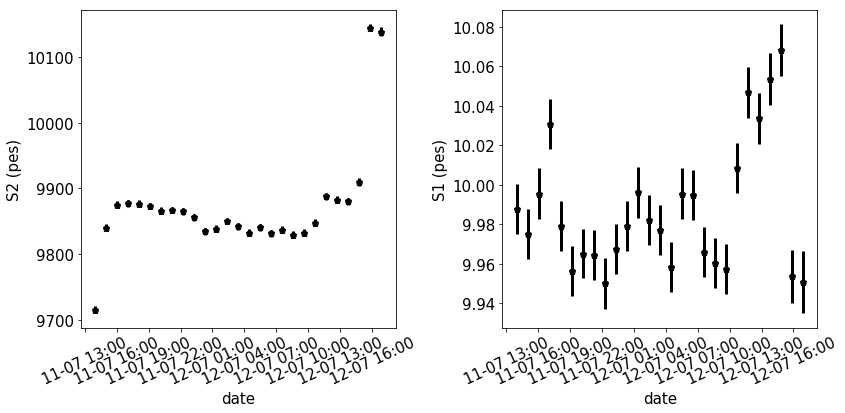

In [72]:
krf.s12_time_profile(kdstc, krNBins.T, krRanges.T, krTimes.timeStamps, figsize=(12,6))

### Time correction

In [73]:
e_mu    = np.nanmean(kdstc.E)
print(e_mu)
e_std   = np.nanstd (kdstc.E)
print(e_std)

9867.97591196
1522.9182598


In [74]:
T   =(kdstc.T - kdstc.T.min()) 
t, e, eu = fitf.profileX(T, kdstc.E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ekr = kdstc.E * ET_correction(T).value
tc, ec, euc = fitf.profileX(T, Ekr, 100)

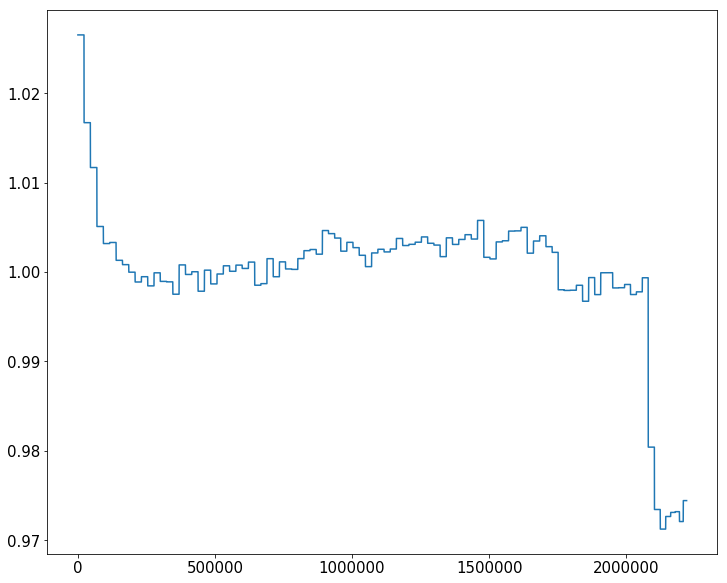

In [75]:
plt.plot(ET_correction(T).value)

In [76]:
ekr_mu    = np.nanmean(Ekr)
ekr_std   = np.nanstd (Ekr)
print(ekr_mu)
print(ekr_std)

9867.97661584
1521.10142522


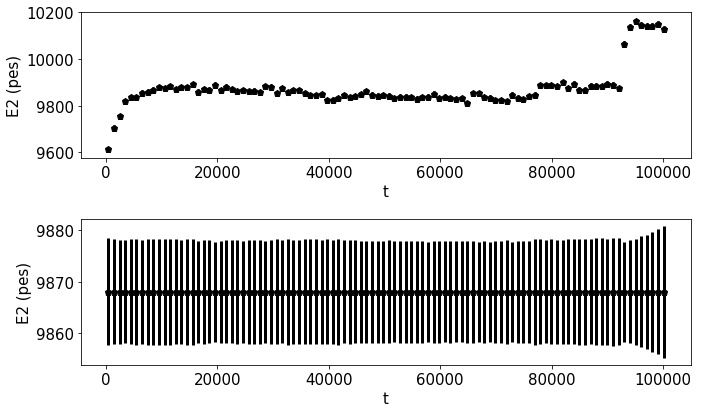

In [77]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)

plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)

plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')
plt.tight_layout()

In [ ]:
dst2 = dst[in_range(dst.T, 90e+3, 10e+4)]

In [ ]:
dst2.columns

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.add_subplot(1, 1, 1)
nevt_full, *_ = plt.hist2d(dstt.X, kdstc.Y, (krBins.XY, krBins.XY))
plt.colorbar().set_label("Number of events")
labels("X (mm)", "Y (mm)", f"full distribution for {krBins.pXY:.1f} mm pitch")


### Notice scale. Time fluctuation below 1 %

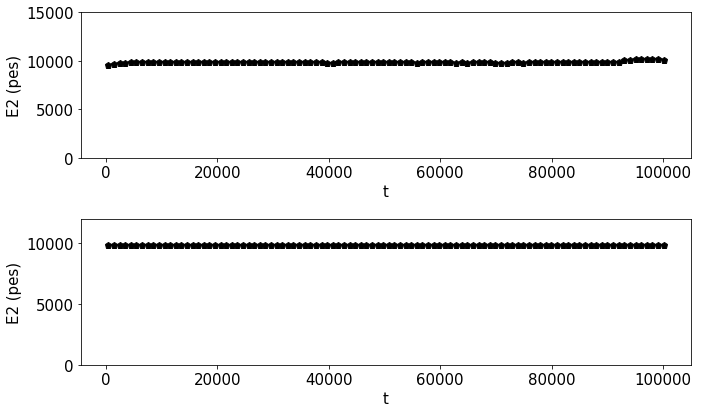

In [78]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)
plt.ylim(0, 15000)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)
plt.ylim(0, 12000)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

plt.tight_layout()



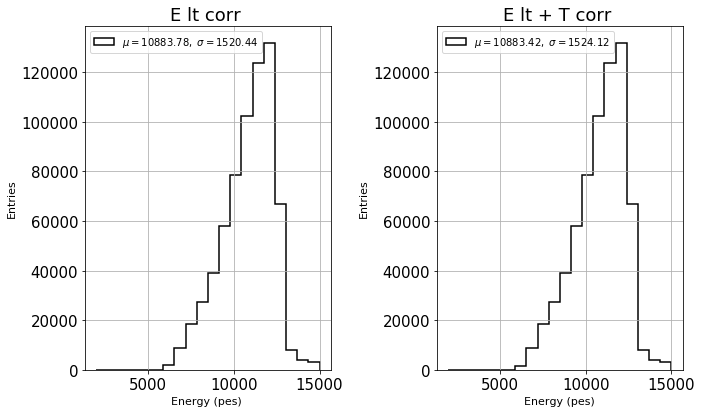

In [80]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (Ec, Ekr),
    bins = (20, 20),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E lt corr ", "E lt + T corr "),
    legends = ("upper left", "upper left"),
    figsize =(10,6))

In [81]:
dst.S2e = E

In [82]:
del dst["index"]

### Write LT DST

In [ ]:

dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)

with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"

